In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.misc import derivative
import numdifftools as nd

In [2]:
IRI = np.loadtxt('IRI6.txt', skiprows=36, usecols = [0,1])
z, N_e = IRI[IRI[:,1]!=-1].T

In [3]:
from astropy.constants import m_e, e, R_earth, c
R_earth = R_earth.to('km').value

In [4]:
def dn2_dr(n, r):
    return derivative(lambda r: n(r)**2, r, dx=1, n=1)
    return nd.Derivative(lambda r: n(r)**2, n=1)(r)

In [5]:
def ode(t, p, n): 
    r,theta,nr,ntheta = p
    if r < R_earth or r > R_earth + 1200e3:
        return [0, 0, 0, 0]
    
    dr_dt = 1/n(r)**2 * nr
    dtheta_dt = 1/(r*n(r)**2) * ntheta
    dnr_dt = 1/(2*n(r)**2) * dn2_dr(n, r) + ntheta * dtheta_dt
    dntheta_dt = 1/r * -ntheta*dr_dt
    return [dr_dt, dtheta_dt, dnr_dt, dntheta_dt]

def solve(n, r0, teta, t, max_step = None):
    nr0 = n(r0)*np.cos(teta)
    ntheta0 = n(r0)*np.sin(teta)
    
    p0 = [r0, 0, nr0, ntheta0]
    sol = solve_ivp(ode, [t[0], t[-1]], p0, args=(n, ),
                    dense_output=True, max_step = max_step)

    return sol.sol(t)

In [6]:
import concurrent.futures
import os

def calc(n, thetas, t, dt, title, imagename):
    colors = plt.cm.viridis(thetas)[::-1]
    D = np.zeros(len(thetas)) * np.nan
    tau = np.zeros(len(thetas)) * np.nan
    fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 9]}, sharey=True, figsize=(12,6))
    with concurrent.futures.ProcessPoolExecutor(max_workers=os.cpu_count()-2) as executor:
        futures = {executor.submit(solve, n, R_earth, theta0, t, dt): i for i, theta0 in enumerate(thetas)}
    for future in concurrent.futures.as_completed(futures):
        i = futures[future]
        try:
            r,theta,nr,ntheta = future.result()
        except Exception as exc:
            print('exception: %s' % (exc))
            continue
        d = theta*R_earth
        z = r - R_earth
        if z[-1] < 500:
            try:
                ihmin = np.where(z<0)[0][0]+1
            except: pass
            ihmax = z[:ihmin].argmax()
            D[i] = interp1d(z[ihmax:ihmin], d[ihmax:ihmin], kind = 'linear', bounds_error=False, fill_value=(np.nan,np.nan))(0)
            tau[i] = interp1d(z[ihmax:ihmin], t[ihmax:ihmin], kind = 'linear', bounds_error=False, fill_value=(np.nan,np.nan))(0)
        axs[1].plot(d, z, c = colors[i], linewidth=0.25, zorder=i)
    axs[0].plot(n(r_),r_ - R_earth)
    axs[0].set_xlabel('Re n')
    axs[1].set_ylim(0, 600)
    axs[1].set_xlim(0, 5e3)
    axs[1].set_xlabel('Distance, km')
    axs[0].set_ylabel('Height, km')
    axs[0].set_xlim(0.5, 1)
    axs[1].set_title(title)
    fig.tight_layout()
    fig.savefig(imagename, dpi=400)
    return D, tau

/usr/lib/python3.11/site-packages/scipy/interpolate/_bsplines.py:490: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.ascontiguousarray(x.ravel(), dtype=np.float_)
/usr/lib/python3.11/site-packages/scipy/interpolate/_bsplines.py:490: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.ascontiguousarray(x.ravel(), dtype=np.float_)
/tmp/ipykernel_494328/456307906.py:2: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda r: n(r)**2, r, dx=1, n=1)
/usr/lib/python3.11/site-packages/scipy/interpolate/_bsplines.py:490: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.ascontiguousarray(x.ravel(), dtype=np.float_)
/tmp/ipykernel_494328/456307906.py:2: DeprecationWarning: scipy.m

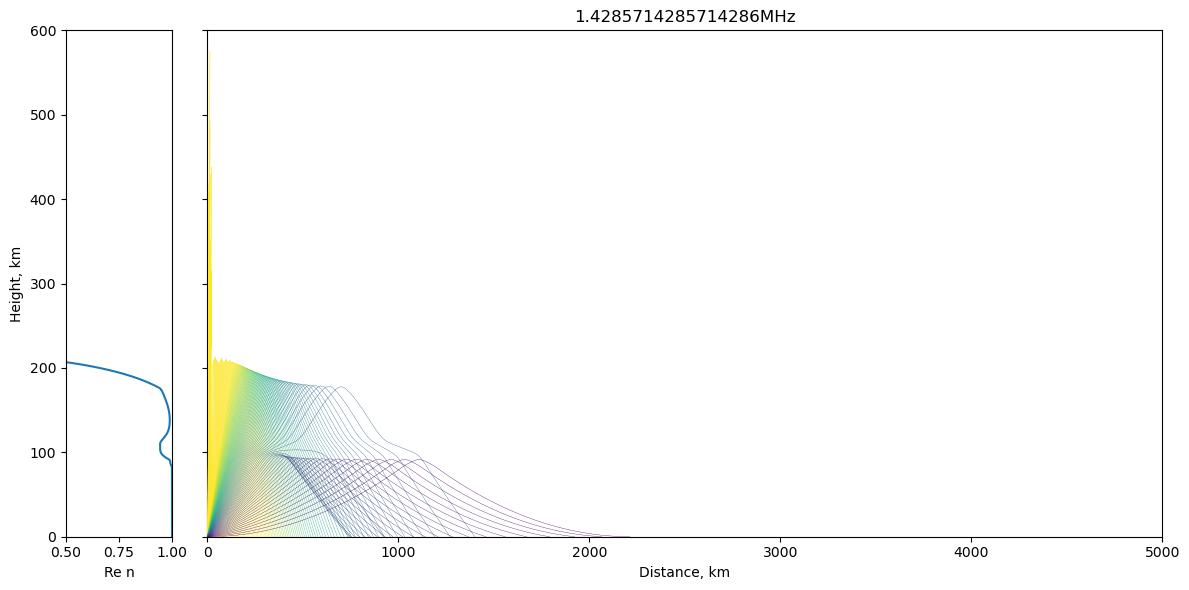

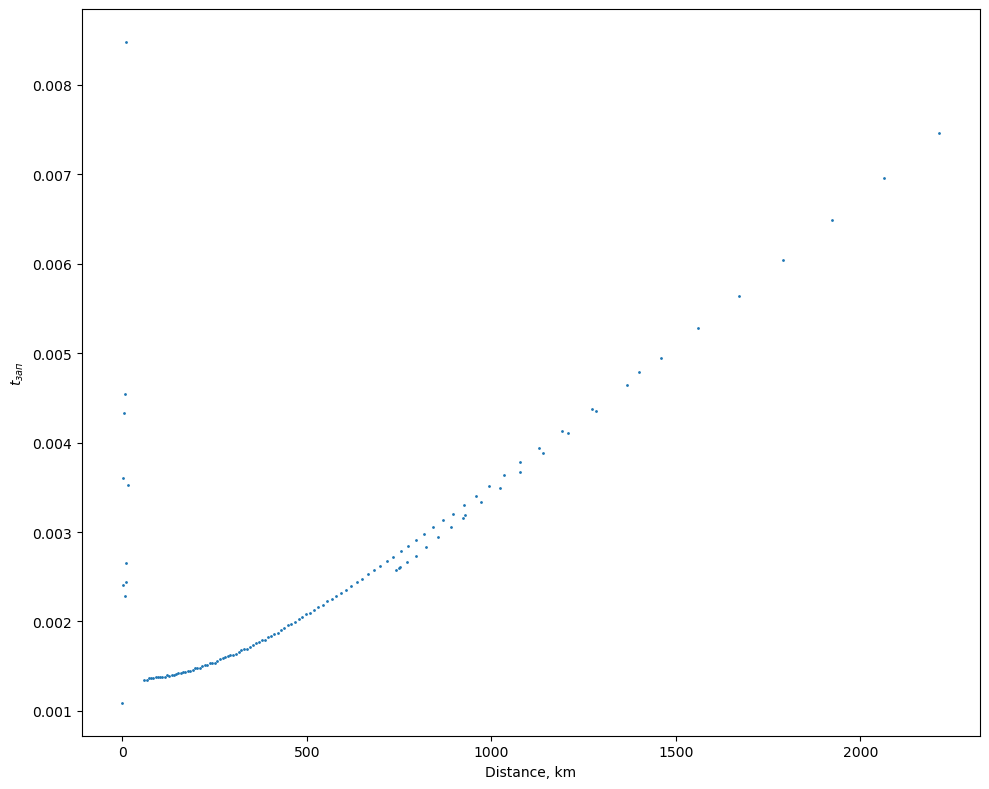

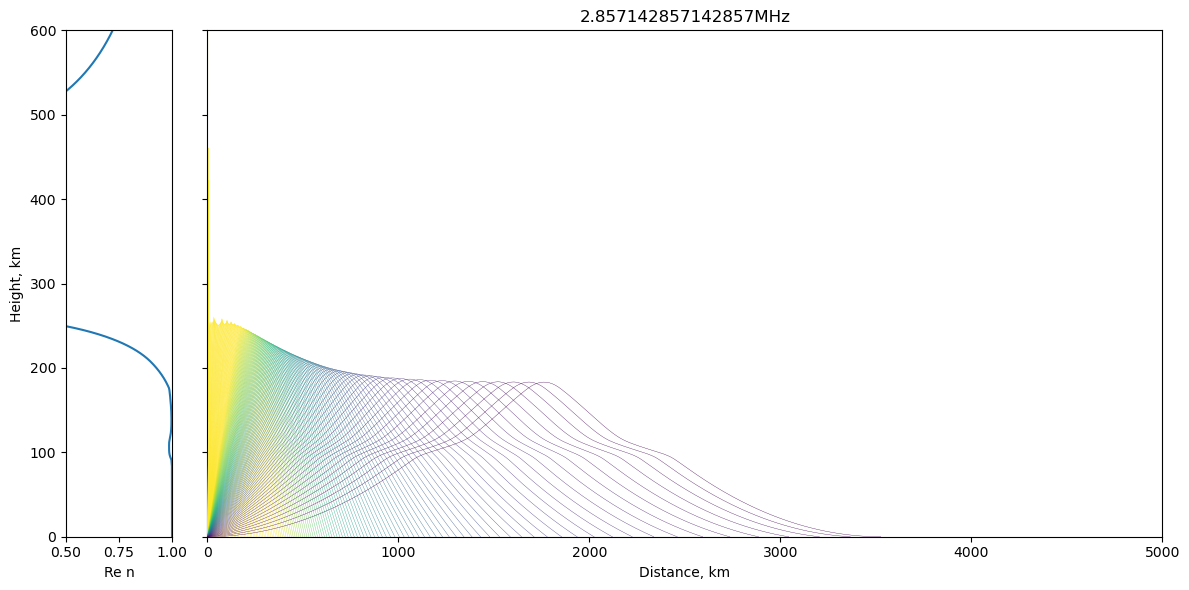

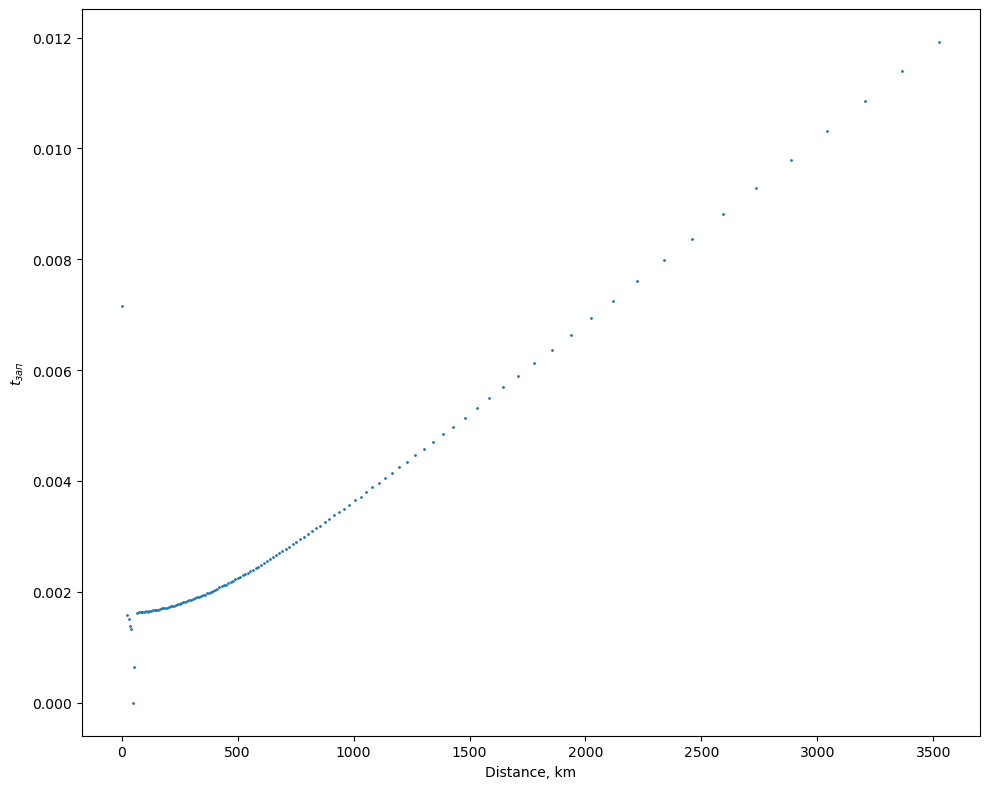

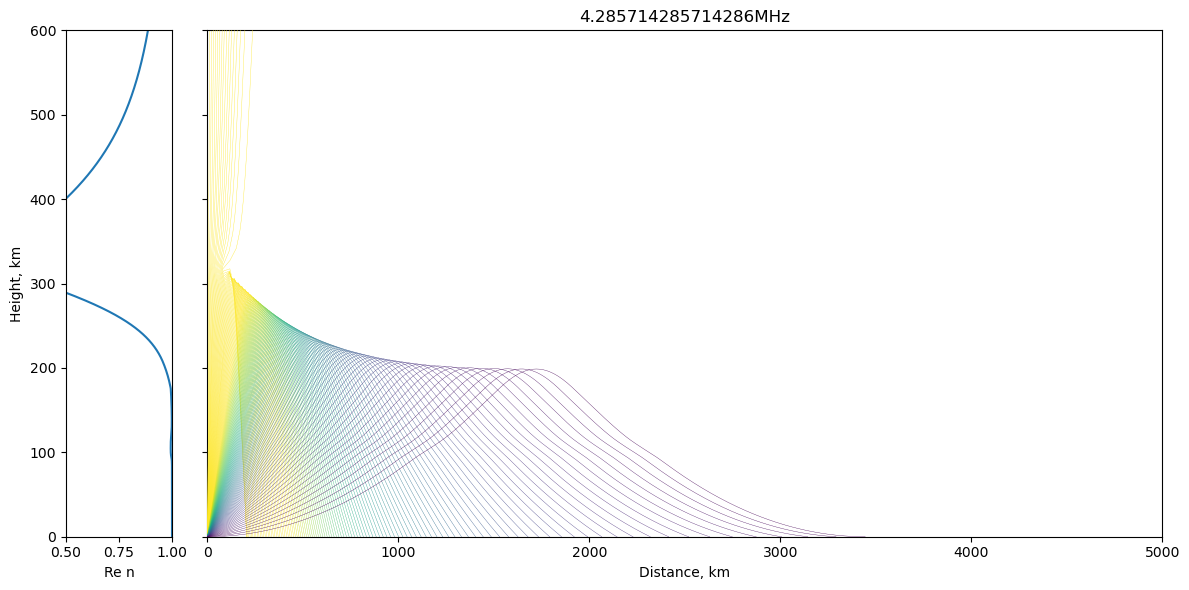

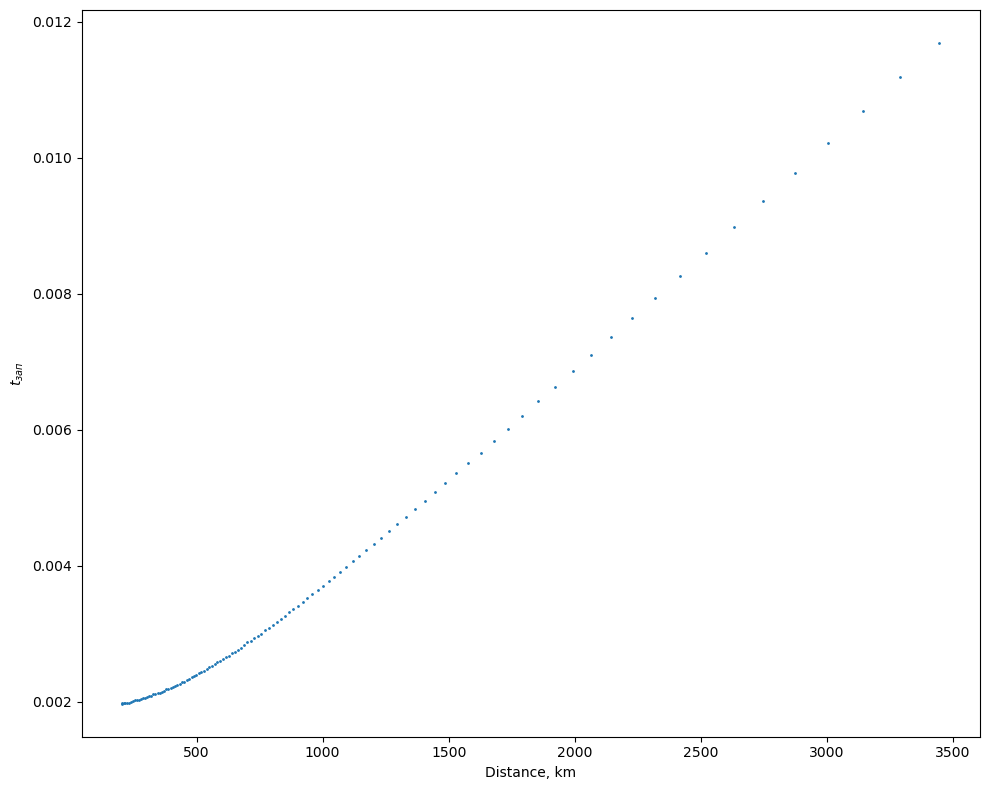

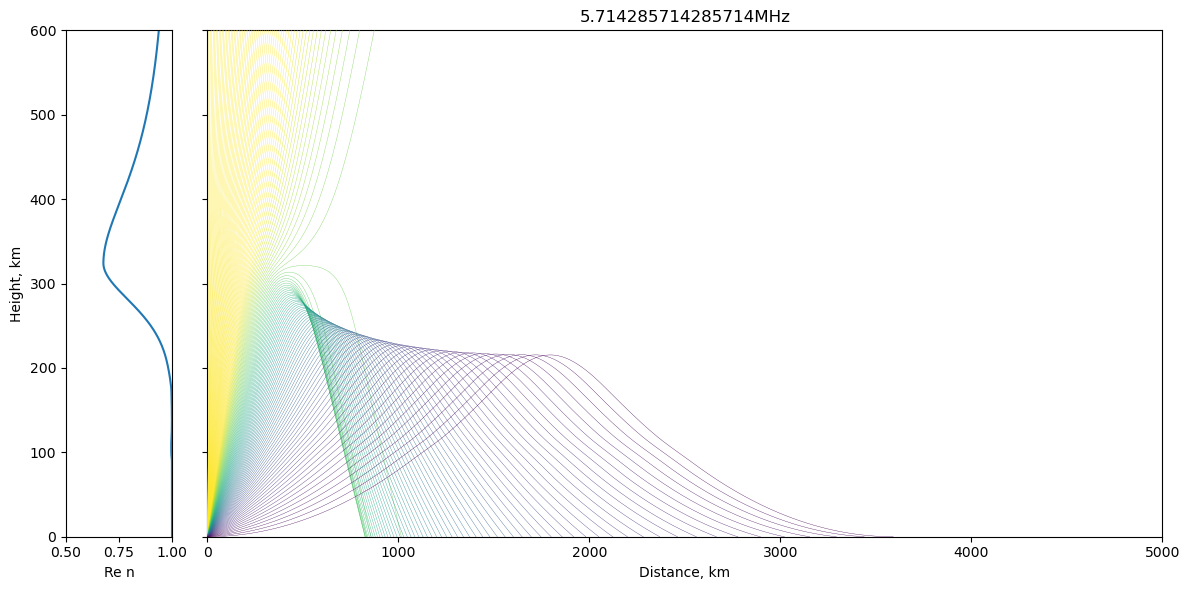

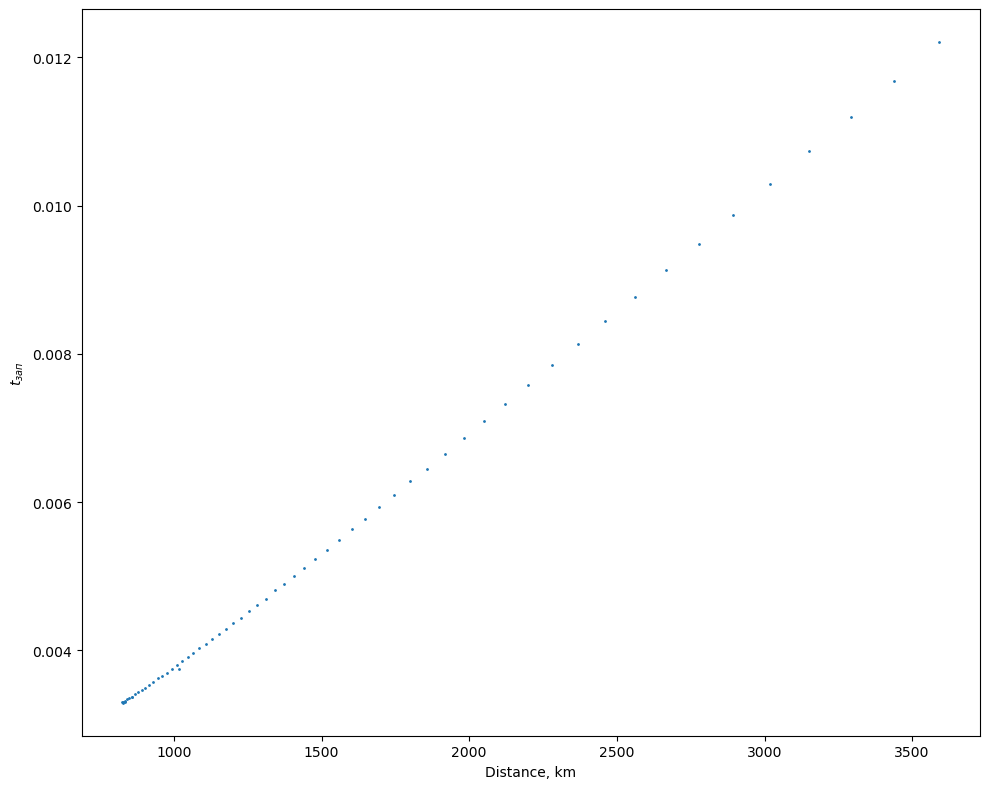

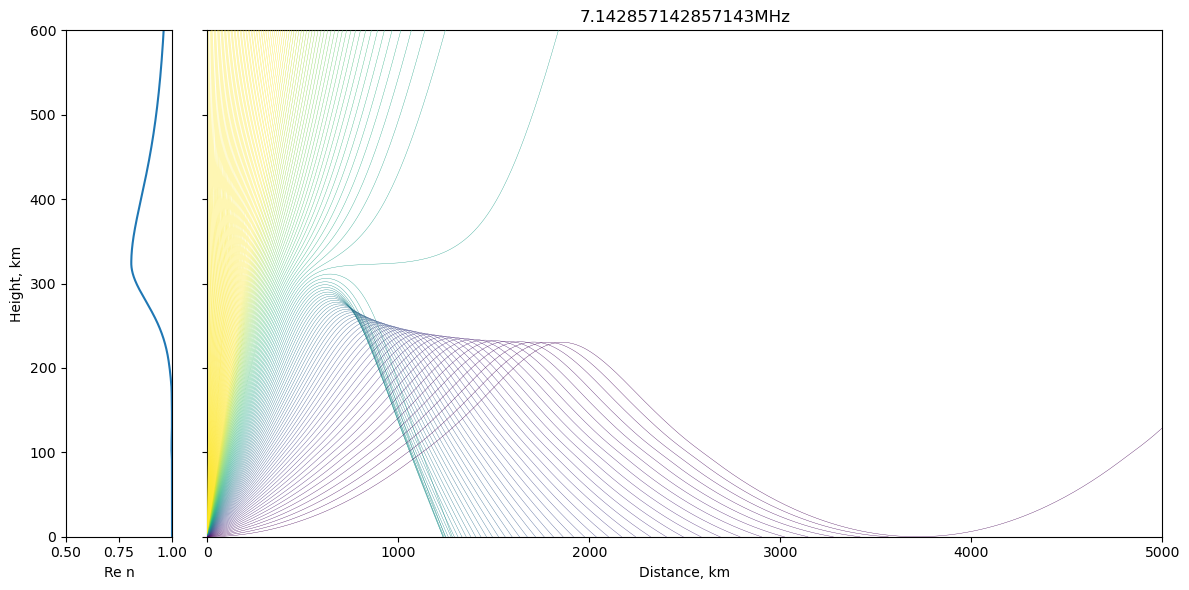

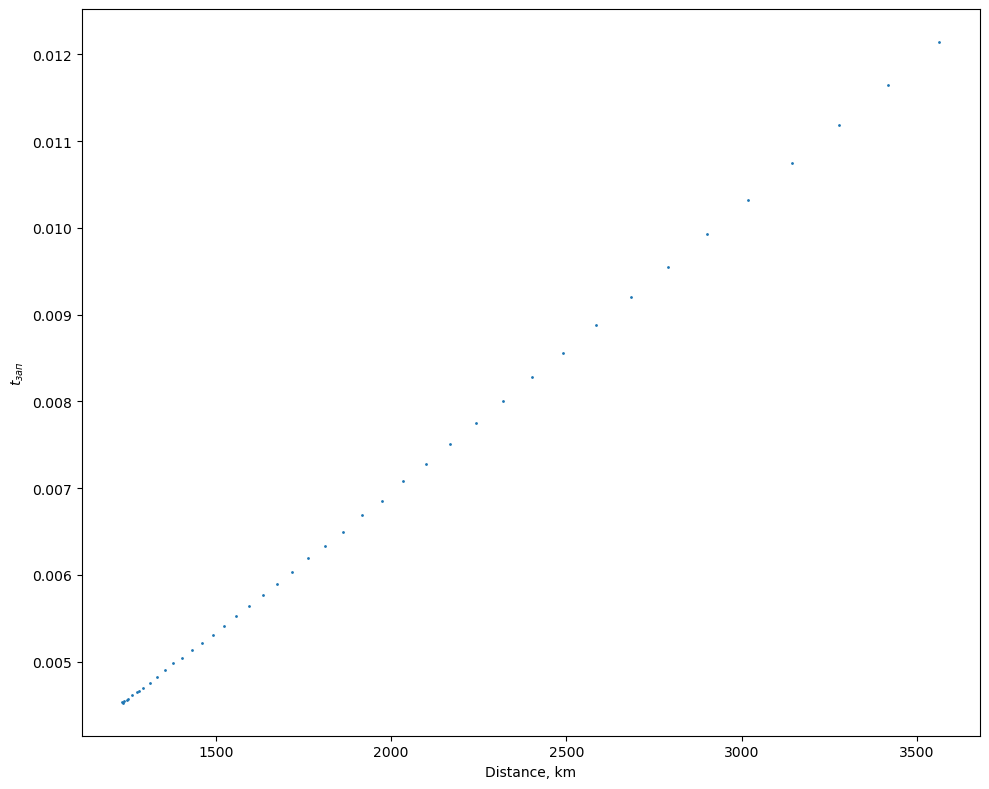

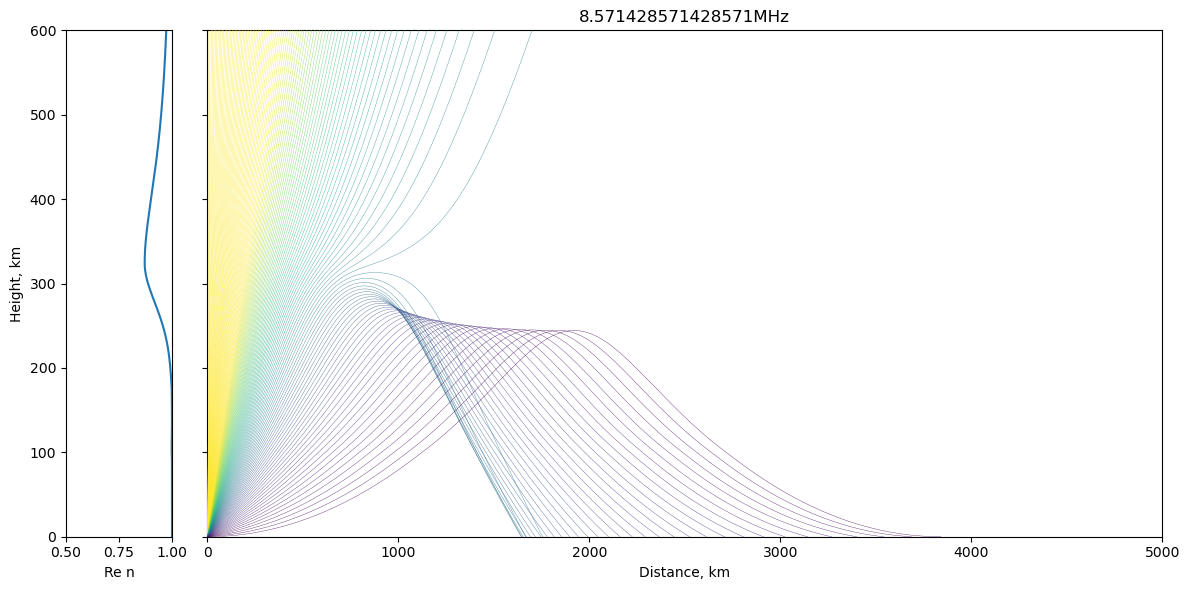

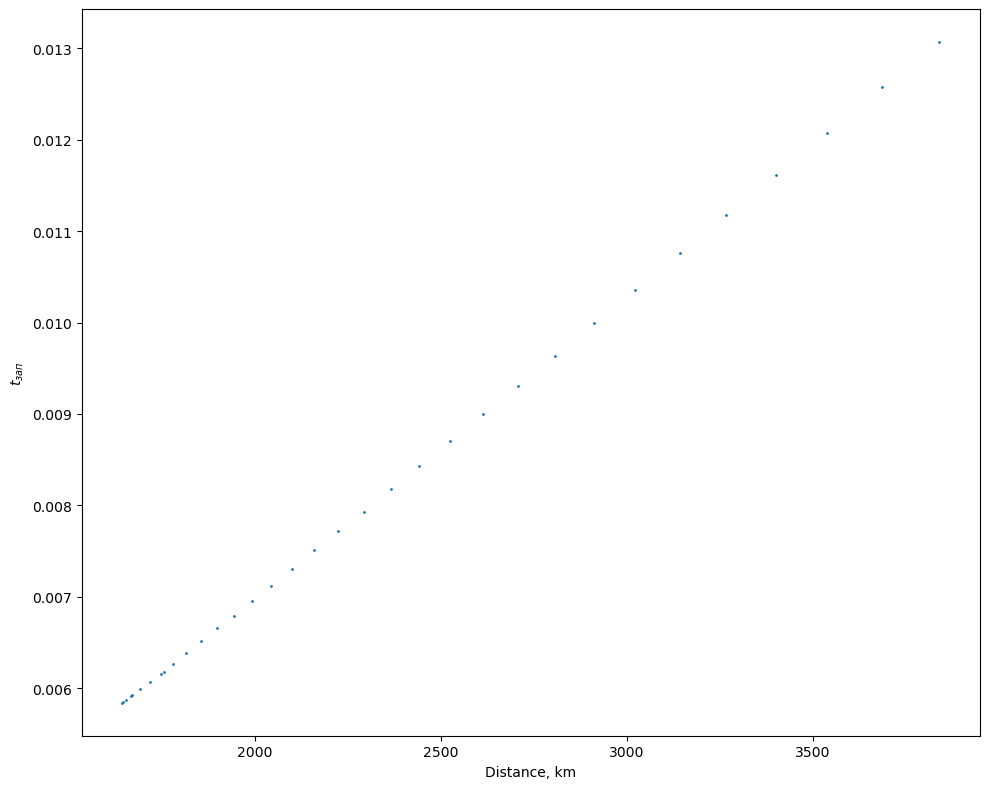

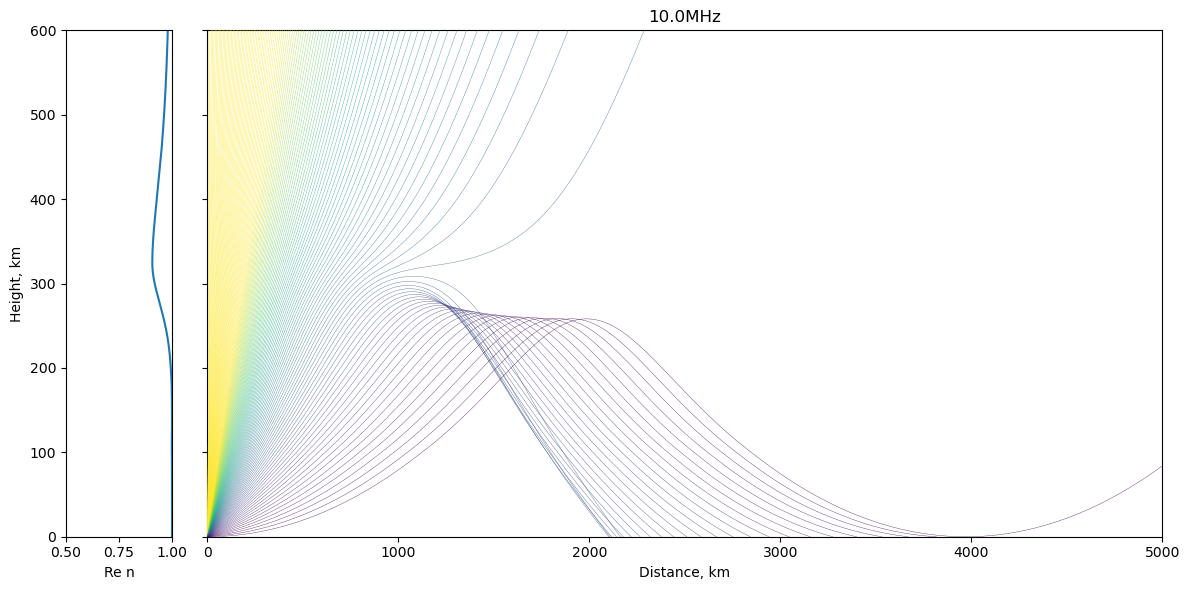

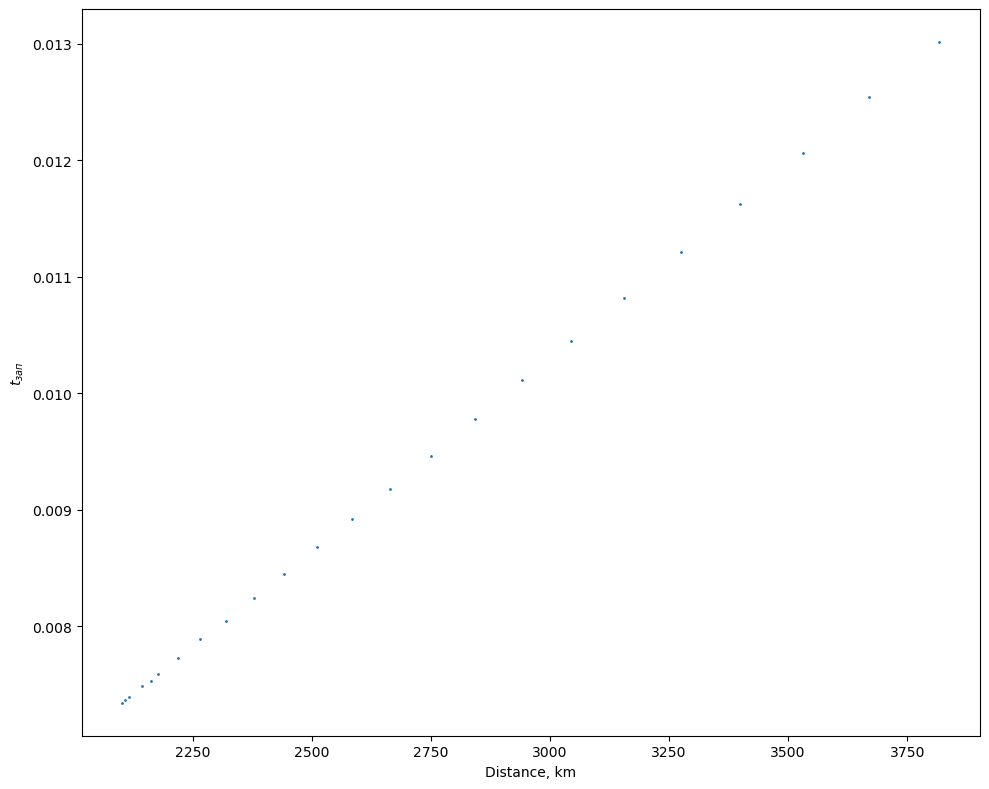

In [7]:
thetas = np.linspace(0,np.pi/2, 2**7)
t = np.linspace(0,8e3, 2**10)
freqs = np.linspace(0, 10, 2**3)[1:]
dt = 5
omega_plasm = np.sqrt((4 * np.pi * (e.gauss.value ** 2) * N_e / m_e.cgs.value))
r = z + R_earth
r_ = np.linspace(R_earth, R_earth+1000, 4096)

for freq in freqs:
    n = np.sqrt(1 + 0j - ((omega_plasm**2)/((2 * np.pi * 1e6 * freq) ** 2)))
    n = interp1d(r, n, kind = 'cubic', bounds_error=False, fill_value=(n[0],n[-1]))
    D, tau = calc(n, thetas, t, dt, f'{freq}MHz', f'{freq}.png')
    t_delay = tau/c.to('km/s').value
    
    plt.figure(figsize=(10,8))
    plt.scatter(D, t_delay, s = 1)
    plt.xlabel('Distance, km')
    plt.ylabel('$t_{зап}$')
    plt.tight_layout()
    plt.tight_layout()
    plt.savefig(f't_{freq}.png')